III. Отримання кількісних даних з зображень
===========================================

_Image Analysis with Python and Napari, Bioinformatics for Ukraine course, 6-24 October 2025, Kyiv, Ukraine._

_© Borys Olifirov, 2025_

__План:__
- Маски в ярлики (labels)
- Порівняння масок
- Вимірювання властивостей ярликів і оцінка перетину масок
- Маскування та простий аналіз 3D зображень (z-стеків та часових рядів)
- Збереження результатів в tidy форматі

---

In [1]:
import numpy as np
import pandas as pd
import skimage  # scikit-image
import matplotlib.pyplot as plt


from templates import module_template as tm  # використаємо попредньо створений модуль

# Аналіз масок та ярлики
---

### Функція для побудови простої маски із завдання до попередньої зустрічі

> [!NOTE]
> Раджу збирати функції з ноутбуків в модулі, щоб не копіювати код з ноутбука в ноутбук і оформити в пакет в подальшому
>

In [2]:
# Можете позичити цю функцію для власного модуля
def simple_masking(image: np.ndarray, median_filter:int=0,
                   closing:int=3, opening:int=3):
    # попередня обробка зображення медіанним фільтром
    preprocessed_image = skimage.filters.median(image,
                                                footprint=skimage.morphology.disk(median_filter))
    
    # побудова маски за допомогою порогу Отсу
    otsu_mask = preprocessed_image > skimage.filters.threshold_otsu(preprocessed_image)
    
    # закриттям маски позбавляємось дрібних прогалин
    pre_filtered_mask = skimage.morphology.closing(otsu_mask,
                                                   footprint=skimage.morphology.disk(closing))

    # відкриттям маски видаляємо дрібні артефакти поза клітиною
    filtered_mask = skimage.morphology.opening(pre_filtered_mask,
                                               footprint=skimage.morphology.disk(opening))
    
    return filtered_mask

Приклад застосування функції

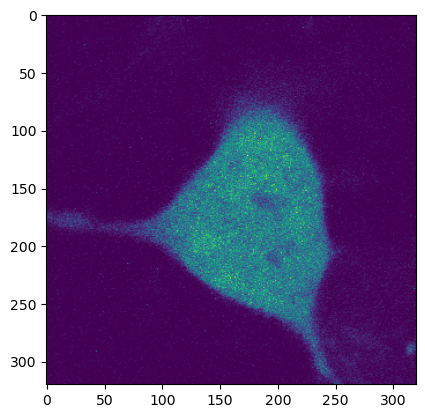

In [3]:
bad_image = skimage.io.imread('demo_data/4D_HEK_spectral_time_series.tiff')[1,4]  # завантаження зображень з використанням skimage
bad_image_corrected = tm.background_correction(bad_image)  # корекція фону з використанням функції з модуля

plt.imshow(bad_image_corrected)

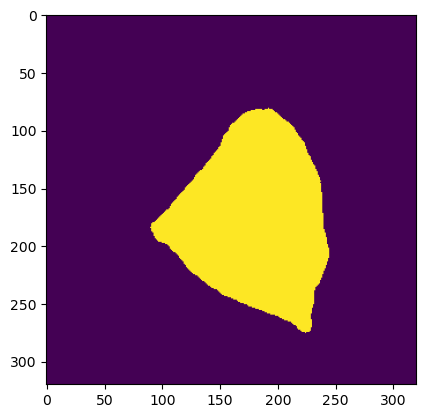

In [4]:
bad_image_mask = simple_masking(bad_image_corrected, median_filter=3, closing=5, opening=5)

plt.imshow(bad_image_mask)

### Різниця між масками та ярликами


##### Завантеження масок для нейрона з попередньої зустрічі


In [5]:
neuron_mask = skimage.io.imread("course_data/neuron_mask.tif")
neuron_mask = neuron_mask.astype(bool)

synapse_mask = skimage.io.imread("course_data/synapse_mask.tif")
synapse_mask = synapse_mask.astype(bool)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/romankoval/BioInUA_2025_img_analysis/course_data/neuron_mask.tif'

> [!NOTE]
> Тут є функція для одночасного відображення двох зображень, що може бути корисною для швидкої візуалізації результатів аналізу.
>

In [6]:
# створимо функцію щоб швидко дивитись на дві маски поруч
def two_mask_side_by_side(mask1: np.ndarray, mask2: np.ndarray):
    plt.figure(figsize=(12, 12))

    plt.subplot(121)
    plt.imshow(mask1, cmap="magma")

    plt.subplot(122)
    plt.imshow(mask2, cmap="magma")

    plt.show()


two_mask_side_by_side(neuron_mask, synapse_mask)

NameError: name 'neuron_mask' is not defined

Обираємо фрагмент маски для наочності

In [ ]:
neuron_mask_crop = neuron_mask[200:600, 800:1000]
synapse_mask_crop = synapse_mask[200:600, 800:1000]

two_mask_side_by_side(neuron_mask_crop, synapse_mask_crop)

Додаткова обробки масок зважаючи на наявні артефакти

In [ ]:
# закривання прогалин в масці нейрона
neuron_mask_fin = skimage.morphology.closing(neuron_mask_crop,
                                             footprint=skimage.morphology.disk(3))

# видалення "снігу" в масці синапсів
synapse_mask_fin = skimage.morphology.opening(synapse_mask_crop,
                                              footprint=skimage.morphology.disk(2))


two_mask_side_by_side(neuron_mask_fin, synapse_mask_fin)

Побудова ярликів для окремих синапсів

In [ ]:
synapse_labels = skimage.measure.label(synapse_mask_fin)
print(f"Кількість синапсів: {synapse_labels.max()}")

two_mask_side_by_side(synapse_mask_fin, synapse_labels)

### Оцінка параметрів яраликів за допомогою `regionprops`

Оцінка властивостей кожного синапсу

In [ ]:
synapse_props = skimage.measure.regionprops(synapse_labels)
print(type(synapse_props))
print(len(synapse_props))

In [ ]:
type(synapse_props[0])

Які властивості доступні?

За детальним переліком можна звернутися до [документації](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops).

In [ ]:
dir(synapse_props[0])

Можна навіть дістати маску окремого синапсу

##### Застосуємо `regionprops` разом з зображенням

Завантаження зображення нейрона

In [ ]:
neuron_z_stack = skimage.io.imread('demo_data/4D_neuron_z-stack.tif')

neuron_image = np.max(neuron_z_stack[:,0], axis=0)[200:600, 800:1000]
synapse_image = np.max(neuron_z_stack[:,1], axis=0)[200:600, 800:1000]

two_mask_side_by_side(neuron_image, synapse_image)

Попередня обробка зображення

In [ ]:
neuron_image = tm.background_correction(neuron_image)
synapse_image = tm.background_correction(synapse_image)

Подивимось взаємозв'язок між розміром синапсів та їх інтенсивністю

In [ ]:
# аналіз властивостей ярликів з урахуванням інтенсивності
synapse_props_full = skimage.measure.regionprops(synapse_labels,
                                                 intensity_image=synapse_image)

In [ ]:
synapse_area_list = []
synapse_intensity_list = []

for prop in synapse_props_full:
    synapse_area_list.append(prop.area)
    synapse_intensity_list.append(prop.intensity_mean)

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(synapse_area_list, synapse_intensity_list, 'o')
plt.xlabel("Площа синапсу (пікселі)")
plt.ylabel("Середня інтенсивність синапсу (a.u.)")
plt.show()

Додамо ще аналіз вмісту білка інтересу в синапсах

In [ ]:
protein_intensity_list = []

# тут ми пробіжемося вручну по синапсам і вирахуємо інтенсивність білка інтересу
for lab in range(1, synapse_labels.max()+1):
    synapse_mask = synapse_labels == lab
    protein_intensity = np.mean(neuron_image[synapse_mask])
    protein_intensity_list.append(protein_intensity)

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(synapse_area_list, synapse_intensity_list, 'o', color='blue', label='Скафолд')
plt.plot(synapse_area_list, protein_intensity_list, 'o', color='red', label='Білок')
plt.xlabel("Площа синапсу (пікселі)")
plt.ylabel("Середня інтенсивність синапсу (a.u.)")
plt.legend()
plt.show()

Подивимось на розподіл морфологічних параметрів синапсів

In [ ]:
synapse_num = 35

plt.figure(figsize=(6,12))
plt.subplot(121)
plt.imshow(synapse_props_full[synapse_num].image)
plt.subplot(122)    
plt.imshow(synapse_props_full[synapse_num].intensity_image, cmap='magma')
plt.show()

In [ ]:
# виокремомо малу та велику осі еліпса
synapse_minor = []
synapse_major = []

for prop in synapse_props_full:
    synapse_minor.append(prop.minor_axis_length)
    synapse_major.append(prop.major_axis_length)

synapse_minor = np.array(synapse_minor)
synapse_major = np.array(synapse_major)


# щоб перевезти розмір у пікселях у мікрометри, треба знати розмір пікселя
pixel_size = 0.18  # мкм/піксель
synapse_major = synapse_major * pixel_size
synapse_minor = synapse_minor * pixel_size


# побудова гістограм розподілу розмірів синапсів
plt.figure(figsize=(6,6))
plt.hist(synapse_minor, bins=30, alpha=0.5, color='blue', label='Мала вісь')
plt.hist(synapse_major, bins=30, alpha=0.5, color='red', label='Велика вісь')
plt.xlabel("Розмір (мкм)")
plt.ylabel("Кількість синапсів")
plt.legend()
plt.show()

### Порівняння масок та колокалізація

In [ ]:
neuron_mask_fin.dtype  # переконаємось, що у нас бінарні маски

Візуалізація одразу двох масок двох масок

> [!NOTE]
> Тут є функція для відображення двох масок на одному зображенні, що може бути корисною для порівняння результатів сегментації.
>

In [ ]:
def two_mask_rgb_overlay(mask1: np.ndarray, mask2: np.ndarray):    

    mask_overlap = np.zeros((*mask1.shape, 3), dtype=np.uint8)  # створюємо порожненє RGB зображення
    mask_overlap[mask1, 0] = 255       # червоним кольором буде відображена маска першого каналу
    mask_overlap[mask2, 1] = 255      # зеленим - другого каналу 

    plt.figure(figsize=(8,8))
    plt.imshow(mask_overlap)
    plt.imshow(mask_overlap)

two_mask_rgb_overlay(neuron_mask_fin, synapse_mask_fin)

In [ ]:
# перетин масок, логічне AND, працює якщо обидві маски bool
neuron_in_synapse_mask = neuron_mask_fin * synapse_mask_fin

# обєднання масок, логічне OR, працює якщо обидві маски bool  
neuron_with_synapse_mask = neuron_mask_fin + synapse_mask_fin


two_mask_rgb_overlay(neuron_with_synapse_mask, neuron_in_synapse_mask)

Розрахуємо відносну площу перетину двох масок (Intersection over Union/IoU або Jaccard index)

In [ ]:
# в даному випадку приклад може бути не дуже вдалий, оскільки маски різної природи,
# і IoU відображає відносну частку маски нейрона, яка розташовується в синапсах

IoU = np.sum(neuron_in_synapse_mask) / np.sum(neuron_with_synapse_mask)
print(f"Intersection over Union (IoU) = {IoU:.4f}")

### Додатковий приклад оцінки колокалізації

Зберемо приклад pipline для оцінки колокалізації аксонів та мієлінових оболонок на візуалізації поперечного перерізу сідничого нерва.

Зважайте, що кожен етап цього демонстраційного прикладу можна покращити, але це вже буде завданням для вас.

In [ ]:
nerve_z_stack = skimage.io.imread('demo_data/4D_nerve_spectral_z-stack.tif')
print(nerve_z_stack.shape)  # (z, s, y, x)

Попередня обробк даних

In [ ]:
# розділимо спектральні канали та отримаємо максимальну проекцію по z для кожного каналу
mip_myelin = np.max(nerve_z_stack[:,0], axis=0)
mip_axon = np.max(nerve_z_stack[:,1], axis=0)

# видалими фонову інтенсивність
mip_myelin = tm.background_correction(mip_myelin)
mip_axon = tm.background_correction(mip_axon)

two_mask_side_by_side(mip_axon, mip_myelin)  # використаємо функцію вже наявну функцію для відображення двох 2D масивів/картинок

Побудуємо початкові маски та ярлики для аксонів та мієлінових оболонок

In [ ]:
# викнемо closing щоб не з'єднати сусідні аксони
# зменшимо opening щоб не відфільтрувати тонкі аксони
mask_axon = simple_masking(mip_axon, median_filter=1, closing=0, opening=2)
labels_axon = skimage.measure.label(mask_axon)
print(f"Кількість аксонів: {labels_axon.max()}")


# викнемо closing щоб не з'єднати сусідні фрагменти мієліну
# більший opening щоб видалити окремі фрагменти мієліну
mask_myelin = simple_masking(mip_myelin, median_filter=1, closing=0, opening=3)
labels_myelin = skimage.measure.label(mask_myelin)
print(f"Кількість фрагментів мієліну: {labels_myelin.max()}")


two_mask_side_by_side(labels_axon, labels_myelin)
two_mask_rgb_overlay(mask_axon, mask_myelin)

Просте маскування не дуже впоралось із такими тонкими структурами, тож для спрощеного аналізу виокремомо тільки ті аксони, що мають мієлінову оболонку.

In [ ]:
# знайдемо фрагменти мієліну, що перетинаються з аксонами
mask_myelin_in_axon = mask_myelin & mask_axon

two_mask_side_by_side(mask_myelin, mask_myelin_in_axon)


# дістанемо значення ярликів мієліна, що перетинаються з аксонами
myelin_in_axon_labels = np.unique(labels_myelin[mask_myelin_in_axon])
print(myelin_in_axon_labels)
print(f"Кількість фрагментів мієліна, що перетинаються з аксонами: {len(myelin_in_axon_labels)}")


# відберемо тільки ті фрагменти мієліна, що перетинаються з аксонами
mask_myelin_in_axon = np.isin(labels_myelin, myelin_in_axon_labels)
two_mask_rgb_overlay(mask_myelin, mask_myelin_in_axon)

In [ ]:
# тепер повторимо відбір для аксонів

# знайдемо аксони, що перетинаються з мієліном
mask_axon_in_myelin = mask_axon & mask_myelin

two_mask_side_by_side(mask_axon, mask_axon_in_myelin)


# дістанемо значення ярликів мієліна, що перетинаються з аксонами
axon_with_myelin_lab = np.unique(labels_axon[mask_axon_in_myelin])
print(axon_with_myelin_lab)
print(f"Кількість фрагментів аксона, що перетинаються з мієліном: {len(axon_with_myelin_lab)}")


# відберемо тільки ті фрагменти мієліна, що перетинаються з аксонами
mask_axon_with_myelin = np.isin(labels_axon, axon_with_myelin_lab)
two_mask_rgb_overlay(mask_axon, mask_axon_with_myelin)

In [ ]:
# подивимось на обидві кінцеві маски
two_mask_rgb_overlay(mask_axon_with_myelin, mask_myelin_in_axon)

Оцінимо колокалізацію аксонів та мієлінових оболонок

> [!NOTE]
> Тут є функція для обчислення IoU між двома масками, що може бути корисною для вас.
>

In [ ]:
# створимо функцію для розрахунку IoU
def iou_calculation(mask1: np.ndarray, mask2: np.ndarray):
    intersection = mask1 * mask2
    union = mask1 + mask2
    iou_val = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0.0
    return iou_val

axons_iou = iou_calculation(mask_axon_with_myelin, mask_myelin_in_axon)
print(f"IoU для аксонів та мієліну: {axons_iou:.4f}")


Подивимось на розподіл морфологічних характеристик аксонів

In [ ]:
# створимо з масок ярлики та обчислюжмо їх з урахуванням інтенсивності початкових зображень
props_axons = skimage.measure.regionprops(labels_axon,
                                          intensity_image=mip_axon)

labels_axon_with_myelin = skimage.measure.label(mask_axon_with_myelin)
props_axons_with_myelin = skimage.measure.regionprops(labels_axon_with_myelin,
                                                     intensity_image=mip_axon)

In [ ]:
# виокремомо малу та велику осі еліпса
axons_all = []
axons_with_myelin = []

for prop, prop_with_myelin in zip(props_axons, props_axons_with_myelin):
    axons_all.append(prop.area)
    axons_with_myelin.append(prop_with_myelin.area)

axons_all = np.array(axons_all)
axons_with_myelin = np.array(axons_with_myelin)


# щоб перевезти розмір у пікселях у мікрометри, треба знати розмір пікселя
pixel_size = 0.09  # мкм^2/піксель
axons_all = axons_all * pixel_size
axons_with_myelin = axons_with_myelin * pixel_size


# побудова гістограм розподілу розмірів синапсів
plt.figure(figsize=(6,6))
plt.hist(axons_all, bins=30, alpha=0.5, color='blue', label='Всі аксони')
plt.hist(axons_with_myelin, bins=30, alpha=0.5, color='red', label='Аксони з мієліном')
plt.xlabel("Площа перерізу (мкм^2)")
plt.ylabel("Кількість аксонів")
plt.legend()
plt.show()

# Застосування масок та ярликів до серій зображень
---

### Застосування масок до 3D зображень

In [ ]:
hek_z_stack = skimage.io.imread('demo_data/3D_HEK_z-stack.tif')
print(hek_z_stack.shape)  # перевіримо розміри зображення

Попередня обробка 3D стеку

In [ ]:
# функція корекції фону працює з 3D зображеннями, тож ми можемо обробити всі площини одразу
hek_z_stack = tm.background_correction(hek_z_stack)

In [ ]:
hek_mip = np.max(hek_z_stack, axis=0)  # максимальна проєкція по Z

# проєкція такого Z-стеку виглядає не дуже корисною, адже ми втрачаємо інформацію про глибину
plt.imshow(hek_mip, cmap='jet')

In [ ]:
# наша проста функція для маскування працює із 3D зображеннями
hek_3d_mask = simple_masking(hek_z_stack, median_filter=3, closing=5, opening=5)

Адаптація простої функції для 3D зображень

In [ ]:
# замінюємо двовимірні морфологічні елементи на тривимірні сфери
def simple_masking_3d(image: np.ndarray, median_filter:int=0,
                   closing:int=3, opening:int=3):
    # попередня обробка зображення медіанним фільтром
    preprocessed_image = skimage.filters.median(image,
                                                footprint=skimage.morphology.ball(median_filter))  # заміна диска на сферу
    
    # побудова маски за допомогою порогу Отсу
    otsu_mask = preprocessed_image > skimage.filters.threshold_otsu(preprocessed_image)
    
    # закриттям маски позбавляємось дрібних прогалин
    pre_filtered_mask = skimage.morphology.closing(otsu_mask,
                                                   footprint=skimage.morphology.ball(closing))  # заміна диска на сферу

    # відкриттям маски видаляємо дрібні артефакти поза клітиною
    filtered_mask = skimage.morphology.opening(pre_filtered_mask,
                                               footprint=skimage.morphology.ball(opening))  # заміна диска на сферу

    return filtered_mask

In [ ]:
hek_3d_mask = simple_masking_3d(hek_z_stack, median_filter=3, closing=5, opening=0)
print(hek_3d_mask.shape)

In [ ]:
z_plane = 5
two_mask_side_by_side(hek_z_stack[z_plane], hek_3d_mask[z_plane])

Подивимось на маску з іншого боку

In [ ]:
hek_3d_mask.shape

In [ ]:
xy_plane = 130
two_mask_side_by_side(hek_z_stack[:,:,xy_plane], hek_3d_mask[:,:,xy_plane])  # не дуже наочно, адже всього 15 шарів по Z

In [ ]:
xy_plane = 130
sides_aspect = 5


# параметр aspect дозволяє змінити співвідношення сторін зображення
plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.imshow(hek_z_stack[:,xy_plane,:], cmap="magma", aspect=sides_aspect)

plt.subplot(122)
plt.imshow(hek_3d_mask[:,xy_plane,:], cmap="magma", aspect=sides_aspect)

plt.show()

Збережемо 3D маску для подальшого використання

In [ ]:
skimage.io.imsave('course_data/3D_hek_mask.tif', hek_3d_mask)

### Застосування масок до візуалізації живих клітин

Завантаження повного 4D стеку для клітин HEK і інспекція каналів

In [ ]:
hek_spectral_and_time = skimage.io.imread('demo_data/4D_HEK_spectral_time_series.tiff')
print(hek_spectral_and_time.shape)

In [ ]:
hek_ch0 = hek_spectral_and_time[0]  # канал 0, кальцієвий індикатор Fluo-4
hek_ch1 = hek_spectral_and_time[1]  # канал 1, білок інтересу
hek_ch2 = hek_spectral_and_time[2]  # канал 2, наскрізне світло


frame_i = 5  # виберемо п'ятий кадр (рахунок з нуля)

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(hek_ch0[frame_i], cmap='magma')
plt.title('Канал 0, Fluo-4')

plt.subplot(132)
plt.imshow(hek_ch1[frame_i], cmap='magma')
plt.title('Канал 1, білок інтересу')

plt.subplot(133)
plt.imshow(hek_ch2[frame_i], cmap='gray')
plt.title('Канал 2, наскрізне світло')

Попередня обробка серії зображень

In [ ]:
# можна обробити весь стек одразу, але 
# але чи це коректно для даних з часовим виміром - питання дискусійне
# альтернативно можна обробити кадри по одному в циклі

# створимо порожні списки для збереження результатів
hek_ca = []
hek_fp = []

# цикл по кадрах одразу двох каналів з виористанням zip
for ca_frame, fp_frame in zip(hek_ch0, hek_ch1):
    hek_ca.append(tm.background_correction(ca_frame))
    hek_fp.append(tm.background_correction(fp_frame))

# перетворимо списки назад в numpy масиви
hek_ca = np.array(hek_ca)
hek_fp = np.array(hek_fp)


А тепер застосуємо створену на самому початку маску для оцінки інтенсивності в кожному кадрі

In [ ]:
hek_mask = bad_image_mask  # замінимо назву на більш підходящу

# пригадаємо маску
plt.imshow(hek_mask)

Розрахуємо інтенсивність в межах маски для кожного кадру з використанням for loop

In [ ]:
ca_intensity_loop = []

for ca_frame in hek_ca:
    ca_intensity_loop.append(np.mean(ca_frame[hek_mask]))

ca_intensity_loop = np.array(ca_intensity_loop)  # перетворимо список в numpy масив для подальшої роботи

plt.plot(ca_intensity_loop)

Розрахуємо інтенсивність в межах маски для кожного кадру з використанням функцій numpy

In [ ]:
ca_intensity = np.mean(hek_ca, axis=(1,2), where=hek_mask)  # використаємо параметр where щоб врахувати маску

plt.plot(ca_intensity)

In [ ]:
fp_intensity = np.mean(hek_fp, axis=(1,2), where=hek_mask)  # розрахуємо інтенсивності і для білка інтересу

# відображення одразу двох профілів зміни інтенсивності
plt.figure(figsize=(6,6))
plt.plot(ca_intensity, '-o', color='blue', label='Ca2+')
plt.plot(fp_intensity, '-o', color='red', label='FP')
plt.xlabel("Кадр")
plt.ylabel("Середня інтенсивність клітини (a.u.)")
plt.legend()
plt.show()

Для порівняння різних дослідів зручно використовувати не абсолютні значення інтенсивності, а амплітуду змін (ΔF)

In [ ]:
# відносні зміни інтенсивності
ca_f0 = np.mean(ca_intensity[:3])  # середня інтенсивність індиатора Ca2+ до стимулу (перші 3 кадри)
fp_f0 = np.mean(fp_intensity[:3])  # середня інтенсивність флуоресцентного білка до стимулу (перші 3 кадри)
print(ca_f0, fp_f0)

ca_df = ca_intensity - ca_f0  # відносні зміни інтенсивності індикатора Ca2+
fp_df = fp_intensity - fp_f0  # відносні зміни інтенсивності флуоресцентного білка


# відображення двох профілів змін інтенсивності
plt.figure(figsize=(6,6))
plt.plot(ca_df, '-o', color='blue', label='Ca2+')
plt.plot(fp_df, '-o', color='red', label='FP')
plt.xlabel("Кадр")
plt.ylabel("Зміни середньої інтенсивності клітини (a.u.)")
plt.legend()
plt.show()

Або навіть відносні зміни (ΔF/F0), вираження у відсотках відносно початкового рівня

In [ ]:
ca_df_f0 = ca_df / ca_f0  # відносні зміни інтенсивності індикатора Ca2+ у відсотках
fp_df_f0 = fp_df / fp_f0  # відносні зміни інтенсивності флуоресцентного білка у відсотках

# відображення двох профілів відносних змін інтенсивності
plt.figure(figsize=(6,6))
plt.plot(ca_df_f0, '-o', color='blue', label='Ca2+')
plt.plot(fp_df_f0, '-o', color='red', label='FP')
plt.xlabel("Кадр")
plt.ylabel("Відносні зміни інтенсивності клітини (ΔF/F0)")
plt.legend()
plt.show()

# Збереження результатів аналізу
---

### "Охайні" дані (Tidy data)

1. Кожна змінна утворює стовпець.
2. Кожне спостереження утворює рядок.
3. Кожен новий набір спостережень утворює східну таблицю.

![TIDY](pic/tidy.png)

Більше про tidy data можна почитати в чудових підручних по аналізу даних з використанням [Python](https://aeturrell.github.io/python4DS/data-tidy.html) та [R](https://r4ds.hadley.nz/data-tidy.html).

__Які дані не є tidy__

- Заголовки стовпців - це значення, а не назви змінних.
- Кілька змінних зберігаються в одному стовпці.
- Змінні зберігаються як у рядках, так і в стовпцях.
- Кілька різних типів одиниць спостереження зберігаються в одній таблиці (наприклад, різні серії дослідів з різними виміряними параметрами).
- Одна одиниця спостереження зберігається в кількох таблицях.

![UNTIDY](pic/untidy.png)

### Зберігаємо результати аналізу морфології та інтенсивності регіонів синапсів

In [ ]:
# створимо перелік колонок вихідної таблиці
neuron_columns = ['id',            # унікальний ідентифікатор зображення що було проаналізоване
                  'synapse_num',   # номер ярлику синапсу в межах зображення
                  'ch',            # канал, білок інтересу ('fp') чи структурний білок ('psd95')
                  'int',           # середня інтенсивність, a.u.
                  'area',          # площа постсинаптичного ущільнення, мкм^2
                  'minor_length',  # мала піввісь постсинаптичного ущільнення, мкм
                  'major_length']  # велика піввісь постсинаптичного ущільнення, мкм

neuron_df = pd.DataFrame(columns=neuron_columns)

# параметри зображення
neuron_id = 'neuron_01'   # унікальний ідентифікатор зображення
neuron_pixel_size = 0.18  # мкм/піксель


Додаємо в таблицю дані для спектрального каналу структурного білка

In [ ]:
for prop in synapse_props_full:
    # створюємо рядок для таблиці у вигляді словника
    synapse_dict = {'id': [neuron_id],                                             # унікальний ідентифікатор зображення
                    'synapse_num': [prop.label],                                   # номер ярлику синапсу в межах зображення
                    'ch': ['psd95'],                                               # канал, білок інтересу
                    'int': [prop.intensity_mean],                                  # середня інтенсивність
                    'area': [prop.area * neuron_pixel_size**2],                    # площа постсинаптичного ущільнення, мкм^2
                    'minor_length': [prop.minor_axis_length * neuron_pixel_size],  # мала піввісь постсинаптичного ущільнення, мкм
                    'major_length': [prop.major_axis_length * neuron_pixel_size]}  # велика піввісь постсинаптичного ущільнення, мкм

    # приєднуємо новий рядок до таблиці
    neuron_df = pd.concat([neuron_df, pd.DataFrame(synapse_dict)], ignore_index=True)

neuron_df.head()  # переглянемо перші 5 рядків таблиці

Додаємо в таблицю дані для спектрального каналу білка інтересу

In [ ]:
# викорастеємо властивості ярликів для синапсів, але інтенсивність візьмемо з каналу білка інтересу
for prop in synapse_props_full:
    synapse_mask = synapse_labels == prop.label  # маска поточного синапсу
    fp_mean_intensity = np.mean(neuron_image, where=synapse_mask)  # середня інтенсивність білка інтересу в синапсі

    synapse_dict = {'id': [neuron_id],                                             # унікальний ідентифікатор зображення
                    'synapse_num': [prop.label],                                   # номер ярлику синапсу в межах зображення
                    'ch': ['fp'],                                                  # канал, білок інтересу
                    'int': [fp_mean_intensity],                                    # середня інтенсивність
                    'area': [prop.area * neuron_pixel_size**2],                    # площа постсинаптичного ущільнення, мкм^2
                    'minor_length': [prop.minor_axis_length * neuron_pixel_size],  # мала піввісь постсинаптичного ущільнення, мкм
                    'major_length': [prop.major_axis_length * neuron_pixel_size]}  # велика піввісь постсинаптичного ущільнення, мкм

    neuron_df = pd.concat([neuron_df, pd.DataFrame(synapse_dict)], ignore_index=True)
    
neuron_df.tail()  # переглянемо перші 5 рядків таблиці

Збережемо таблицю в файл CSV

In [ ]:
print(f"Загальна кількість синапсів в таблиці: {neuron_df.shape[0]}")
neuron_df.to_csv('course_data/neuron_synapse_analysis.csv', index=False)  # збережемо таблицю в файл CSV

### Зберігаємо результати аналізу змін концентрації кальцію в часі

In [ ]:
# створимо перелік колонок вихідної таблиці
hek_columns = ['id',            # унікальний ідентифікатор зображення що було проаналізоване
               'frame_num',  # номер кадру
               'time',       # абсолютний час від початку зйомки, с
               'ch',         # канал, індикатор кальцію ('ca') чи білок інтересу ('fp')
               'int',        # середня інтенсивність, a.u.
               'int_df',     # зміна інтенсивності, ΔF
               'int_df_f0']  # відносна зміна інтенсивності, ΔF/F0

hek_df = pd.DataFrame(columns=hek_columns)

# параметри зображення
hek_id = 'hek_01'                       # унікальний ідентифікатор зображення
hek_frame_rate = 2                      # інтервал між кадрами 2 секунди
hek_frames_num = ca_intensity.shape[0]  # кількість кадрів у серії
hek_time_line = np.linspace(0,                                 # початок відліку часу
                           (hek_frames_num-1)*hek_frame_rate,  # кінець відліку часу
                           num=hek_frames_num)                 # кількість часових точкок

print(hek_time_line)

Додаємо результати аналізу в таблицю

In [ ]:
# при створенні таблиці масиви значень треба перетворити в списки
ca_dict = {'id': [hek_id]*hek_frames_num,             # унікальний ідентифікатор зображення
           'frame_num': list(range(hek_frames_num)),  # номер кадру
           'time': list(hek_time_line),               # абсолютний час від початку зйомки, с
           'ch': ['ca']*hek_frames_num,               # канал, індикатор кальцію
           'int': list(ca_intensity),                 # середня інтенсивність, a.u.
           'int_df': list(ca_df),                     # зміна інтенсивності, ΔF
           'int_df_f0': list(ca_df_f0)}               # зміна інтенсивності, ΔF/F0

fp_dict = {'id': [hek_id]*hek_frames_num,             # унікальний ідентифікатор зображення
           'frame_num': list(range(hek_frames_num)),  # номер кадру
           'time': list(hek_time_line),               # абсолютний час від початку зйомки, с
           'ch': ['fp']*hek_frames_num,               # канал, індикатор кальцію
           'int': list(fp_intensity),                 # середня інтенсивність, a.u.
           'int_df': list(fp_df),                     # зміна інтенсивності, ΔF
           'int_df_f0': list(fp_df_f0)}               # зміна інтенсивності, ΔF/F0

# приєднуємо нові рядки до таблиці
hek_df = pd.concat([hek_df, pd.DataFrame(ca_dict), pd.DataFrame(fp_dict)], ignore_index=True)

hek_df.head()  # переглянемо перші 5 рядків таблиці

Збережемо таблицю в файл CSV

In [ ]:
hek_df.to_csv('course_data/hek_time_series_analysis.csv', index=False)

# Пакети python
---

Пакети python представляють набір модулів, що об'єднані спільною тематикою або призначенням. Вони дозволяють організувати код, полегшити його повторне використання та спростити управління залежностями.

Для перетворення набору модулів у пакет, створюється директорія з ім'ям пакету, яка містить файл `__init__.py` (може бути порожнім).

Додаткові файли в складі пакету включають службовий файл `pyproject.toml` (для опису метаданих пакету і залежностей пакету), `README.md` (для документації) та `LICENSE` (для ліцензії).

Структура шаблону пакету python:

```
└── package-template/          # директорія пакету
    ├── src/                       # загальна директорія із вихідним кодом пакету
    │   └── package_template/      # директорія із модулями пакету
    │       ├── __init__.py        # службовий файл директорії
    │       └── module.py          # код модуля у складі пакету
    │
    ├── pyproject.toml        # конфігураційний файл
    ├── README.md             # файл опису
    ├── LICENSE               # ліцензія
    └── .gitignore            # службовий файл git
```

# Завдання
---

Щодо аналізу даних:
- Адаптувати роглянуті підходи до аналізу зображень, створити функцію що дозволяла би отримати декілька параметрів демонстріціно зображення та зберігала би їх у вигляді tidy data frame. Опис параметрів, що необхідно оцінити можна знайти в завданнях до демонстраційних даних у файлі `DESCRIPTION.md`.
- За наявності власних зображень, створити аналогічну функцію для оцінки цікавих вам параметрів (інтенсивності регіонів інтересу, площі, накладання масок для різних спектральних каналів тощо).


Щодо оформлення коду:
- Зібрати всі функції що були створені впродовж зустрічей в модуль.
- Створити копію шаблону пакету python в вашій робочій директорії `course_data`.
- Розмістити створений модуль в директорії пакету та відредагувати конфугіраційний файл `pyproject.toml`.
- За наявності власних функцій створених впродовж роботи, додати їх до створеного пакету.
- Встановити пакет в editable режимі.